In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
sns.set()

In [94]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm

from tqdm import tqdm_notebook

from itertools import product

In [95]:
#Read the data
DecAdData = pd.read_csv('DecemberAdData.csv',header = None)
DecCols = pd.read_csv('DecemberCols.csv',header = None)
M_Cols = pd.read_csv('MarketingCols.csv',header = None)
M_Sales = pd.read_csv('MarketingSales.csv',header = None)

In [96]:
#Assign the column name and prepare the data and predict dataset
DecAdData.columns = DecCols.values.flatten()
M_Sales.columns = M_Cols.values.flatten()
DecAdData['Date'] = pd.to_datetime(DecAdData['Date'],dayfirst=True)
DecAdData.set_index('Date', inplace=True)
DecAdData.index = DecAdData.asfreq('d').index
M_Sales['Date'] = pd.to_datetime(M_Sales['Date'],dayfirst=True)
M_Sales.set_index('Date', inplace=True)
M_Sales.index = M_Sales.asfreq('d').index


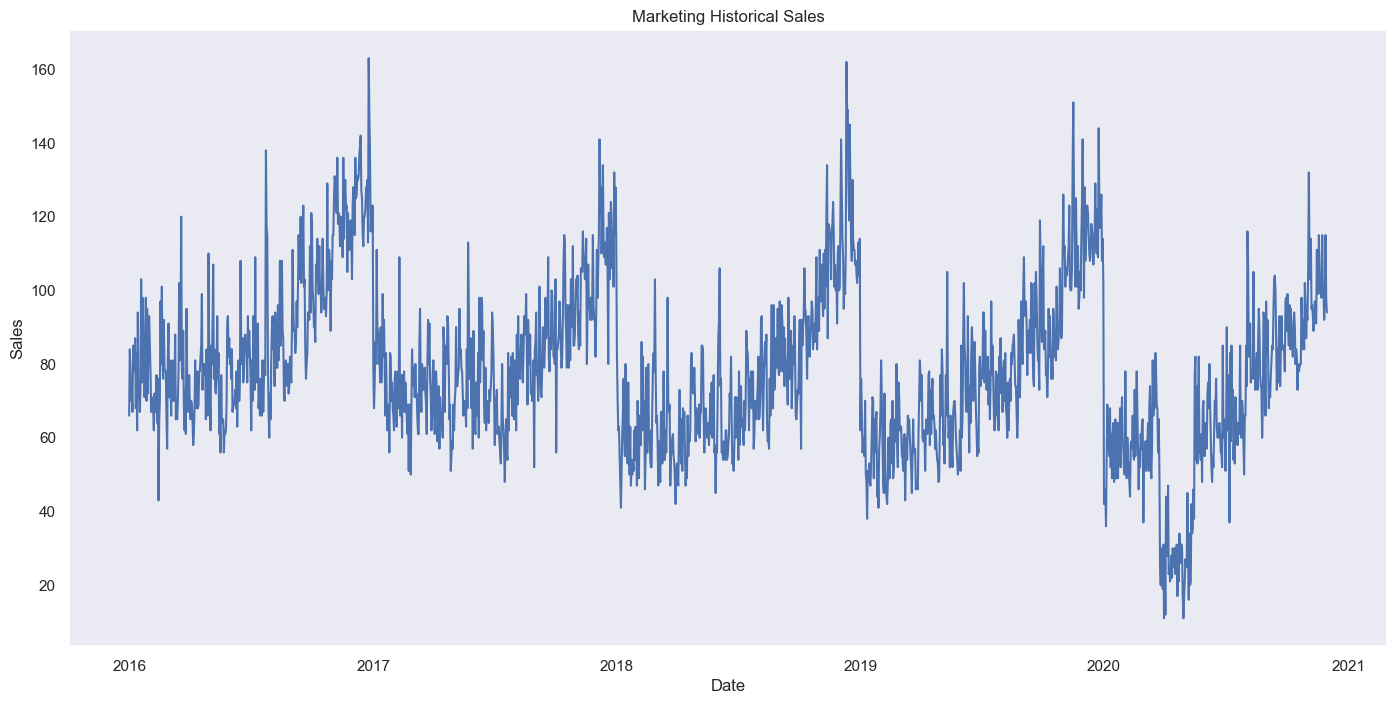

In [97]:
# Plot Sales over all
plt.figure(figsize=(17, 8))
plt.plot(M_Sales.Sales,zorder=1)
plt.title('Marketing Historical Sales')
plt.ylabel('Sales')
plt.xlabel('Date')
plt.grid(False)
plt.show()

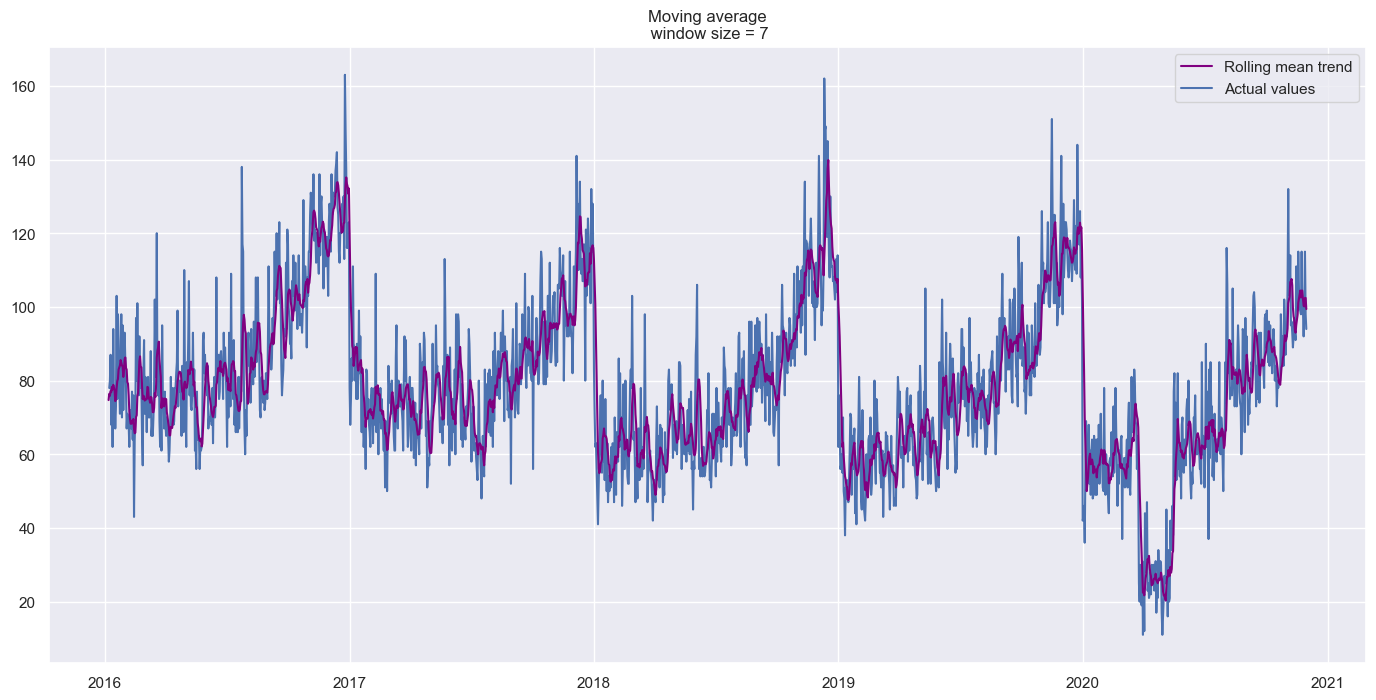

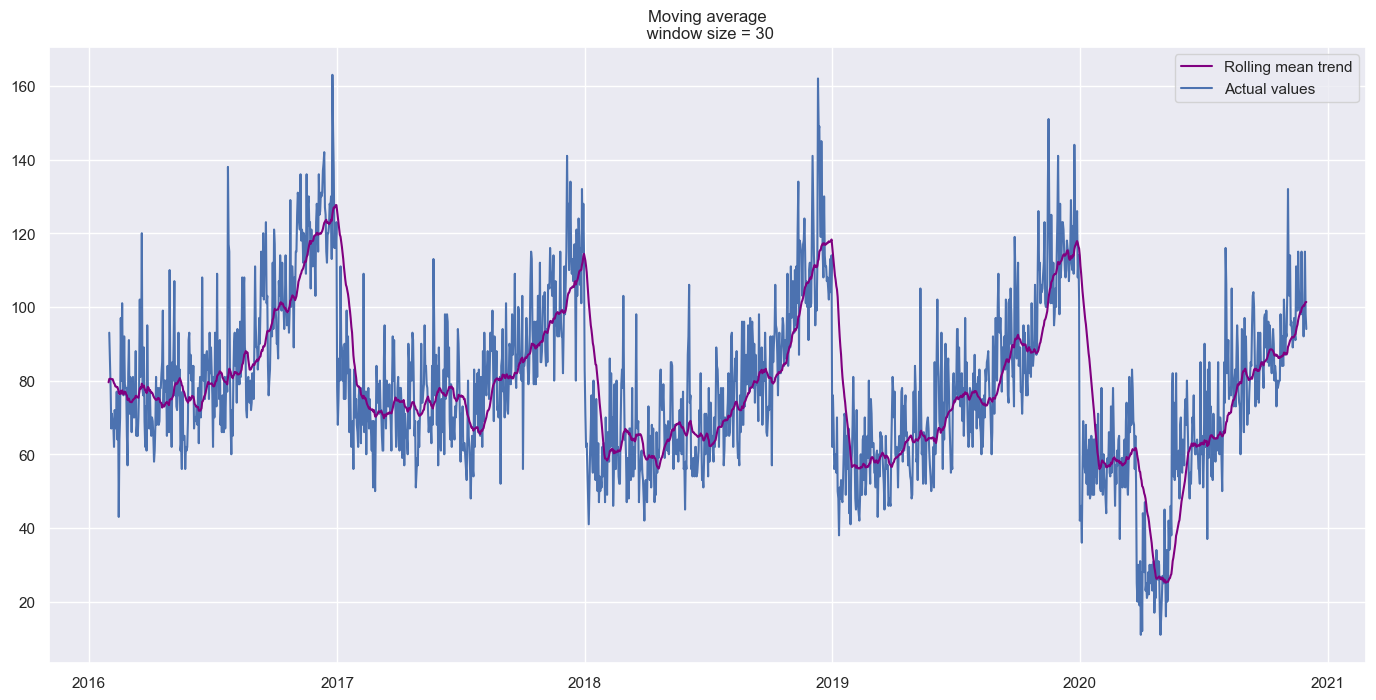

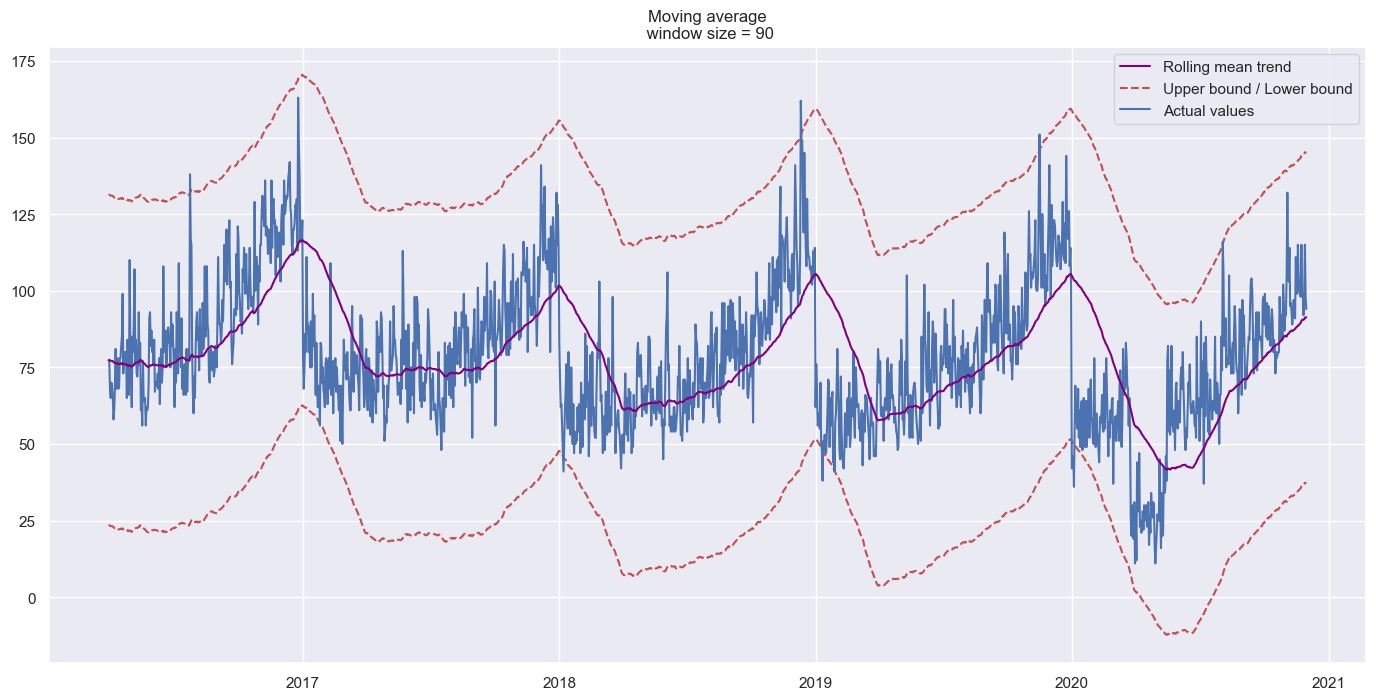

In [98]:
#Use the moving average model to smooth our time series
#define a Helper function to run the moving average model and plot them in different period windows
def plot_moving_average(series, window, plot_intervals=False, scale=1.96):

    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(17,8))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'purple', label='Rolling mean trend',zorder=3)
    
    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')
            
    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)
    
#Smooth by the previous 7 days (by week)
plot_moving_average(M_Sales.Sales, 7)

#Smooth by the previous month (30 days)
plot_moving_average(M_Sales.Sales, 30)

#Smooth by previous quarter (90 days)
plot_moving_average(M_Sales.Sales, 90, plot_intervals=True)

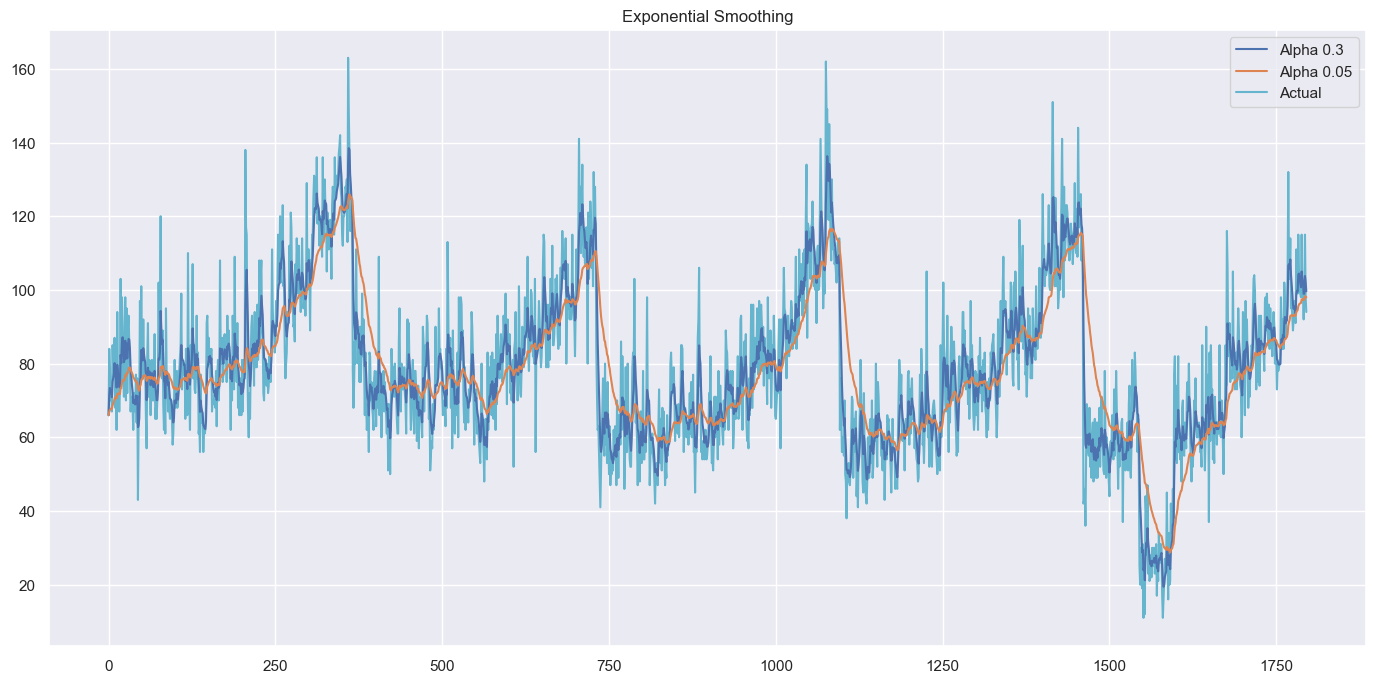

In [99]:
#Exponential smoothing
#Using a helper function to check exponential smoothing to see if it can pick up a better trend
def exponential_smoothing(series, alpha):

    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result
  
def plot_exponential_smoothing(series, alphas):
 
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha),zorder=3)
    plt.plot(series.values, "c", label = "Actual",zorder=1)
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True);

plot_exponential_smoothing(M_Sales.Sales, [0.3,0.05])
#an alpha value of 0.05 smoothed the curve while picking up most of the upward and downward trends.

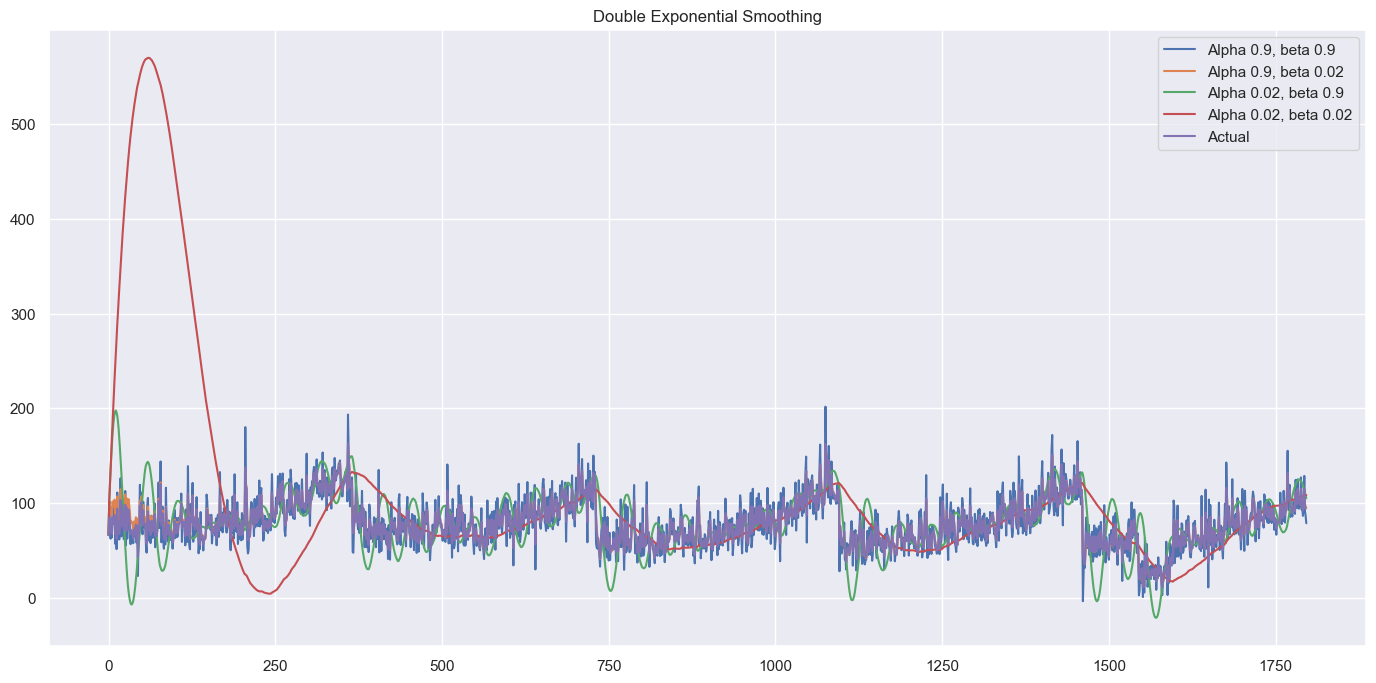

In [100]:
#Double exponential smoothing
#experiment with different alpha and beta combinations to get better looking curves.
def double_exponential_smoothing(series, alpha, beta):

    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result

def plot_double_exponential_smoothing(series, alphas, betas):
     
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        for beta in betas:
            plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(series.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)
    
plot_double_exponential_smoothing(M_Sales.Sales, alphas=[0.9, 0.02], betas=[0.9, 0.02])

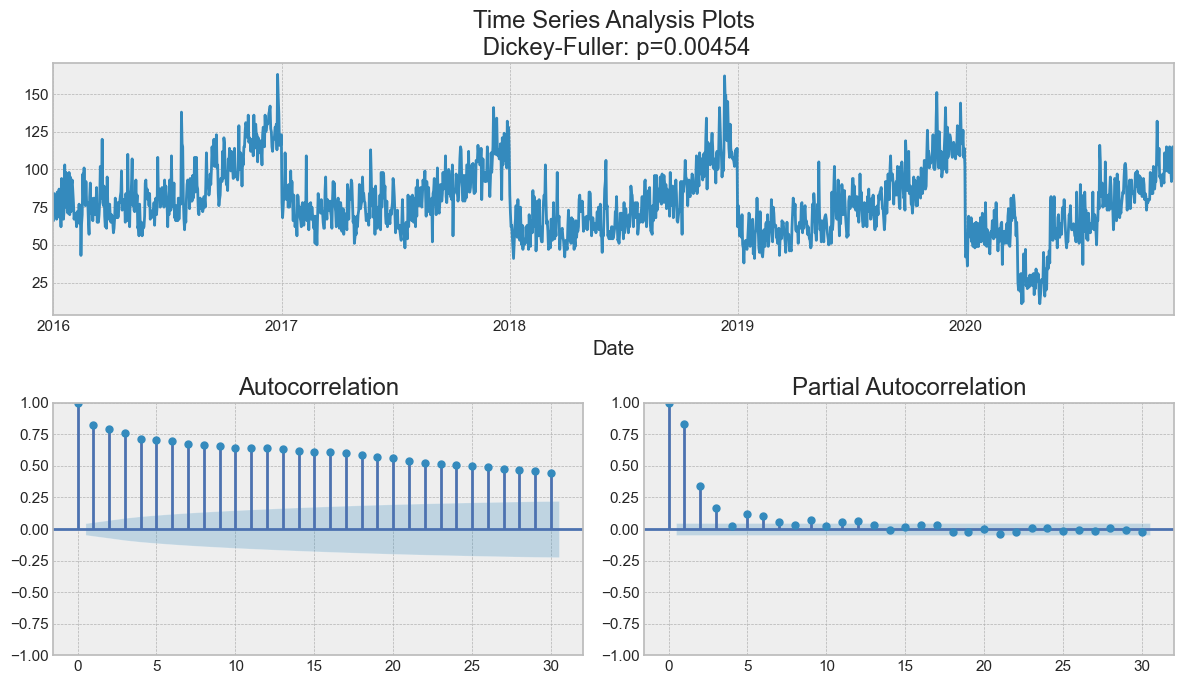

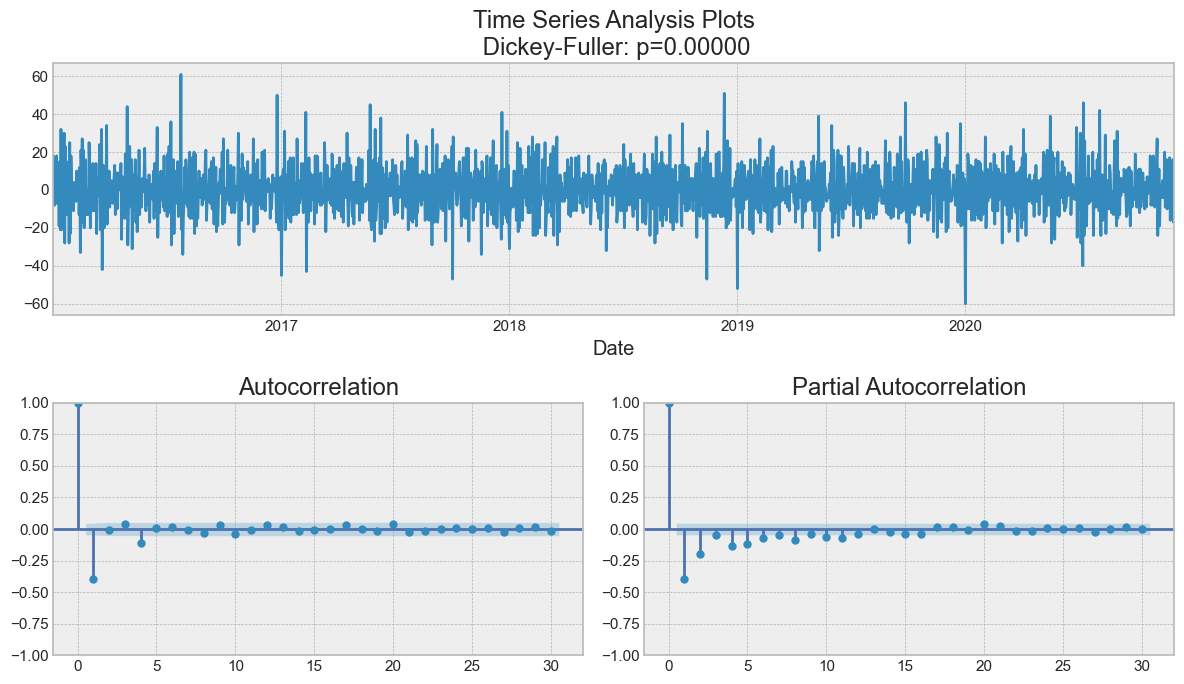

In [101]:
#need to turn our series into a stationary process in order to model it. Therefore, let’s apply the Dickey-Fuller test to see if it is a stationary process.
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        
tsplot(M_Sales.Sales, lags=30)

# Take the first difference to remove to make the process stationary
data_diff = M_Sales.Sales - M_Sales.Sales.shift(1)

tsplot(data_diff[1:], lags=30)

In [102]:
#make the training dataset with extra features
x = M_Sales[['PositiveNews','NegativeCoverage','Competition','0508Line_247','UltraEdition_Available','COVID_Lockdown','AdvertisingSpend','Month']]
x

,PositiveNews,NegativeCoverage,Competition,0508Line_247,UltraEdition_Available,COVID_Lockdown,AdvertisingSpend,Month
Date,,,,,,,,
2016-01-01,0,0,0,1,0,0,4199.86,January
2016-01-02,0,0,0,1,0,0,14768.20,January
2016-01-03,0,0,0,1,0,0,11019.79,January
2016-01-04,0,0,0,1,0,0,3358.30,January
2016-01-05,0,0,0,1,0,0,5207.19,January
...,...,...,...,...,...,...,...,...
2020-11-26,0,0,1,0,1,0,2238.03,November
2020-11-27,0,0,1,0,1,0,6378.24,November
2020-11-28,1,0,1,0,1,0,12670.48,November


In [103]:
#encode month for training purpose
x['Month'] = pd.to_datetime(x['Month'], format='%B').dt.month
x_np=x.to_numpy()

In [104]:
#make addtinal regressors in to prediction dataset
DecAdData['PositiveNews'] = 0
DecAdData['NegativeCoverage'] = 0
DecAdData['Competition'] = 0
DecAdData['0508Line_247'] = 0
DecAdData['UltraEdition_Available'] = 1
DecAdData['COVID_Lockdown'] = 0
DecAdData

,AdvertisingSpend,Month,Day,PositiveNews,NegativeCoverage,Competition,0508Line_247,UltraEdition_Available,COVID_Lockdown
Date,,,,,,,,,
2020-12-01,10568.28,December,Tuesday,0,0,0,0,1,0
2020-12-02,8218.31,December,Wednesday,0,0,0,0,1,0
2020-12-03,4907.38,December,Thursday,0,0,0,0,1,0
2020-12-04,8057.25,December,Friday,0,0,0,0,1,0
2020-12-05,21481.50,December,Saturday,0,0,0,0,1,0
2020-12-06,484.17,December,Sunday,0,0,0,0,1,0
2020-12-07,12172.13,December,Monday,0,0,0,0,1,0
2020-12-08,8991.64,December,Tuesday,0,0,0,0,1,0
2020-12-09,16149.41,December,Wednesday,0,0,0,0,1,0


In [105]:
#reorder the columns in prediction dataset
cols = DecAdData.columns.tolist()
cols = cols[3:10]+cols[0:2]
cols

['PositiveNews',
 'NegativeCoverage',
 'Competition',
 '0508Line_247',
 'UltraEdition_Available',
 'COVID_Lockdown',
 'AdvertisingSpend',
 'Month']

In [106]:
#make the predition dataset
forecast_x = DecAdData[cols]
forecast_x['Month'] = pd.to_datetime(forecast_x['Month'], format='%B').dt.month
forecast_x_np=forecast_x.to_numpy()

In [107]:
#SARIMAX
#Set initial values and some bounds
ps = range(0, 2)
d = 1
qs = range(0, 2)
Ps = range(0, 2)
D = 1
Qs = range(0, 2)
#weekly trend
s = 7

#Create a list with all possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

16

In [108]:
# Train many SARIMA models to find the best set of parameters
def optimize_SARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
    """
    
    results = []
    best_aic = float('inf')
    
    for param in tqdm_notebook(parameters_list):
        try: model = sm.tsa.statespace.SARIMAX(M_Sales.Sales, order=(param[0], d, param[1]),exog=x,
                                               seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        
        #Save best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])
        
    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    #Sort in ascending order, lower AIC is better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

result_table = optimize_SARIMA(parameters_list, d, D, s)

#Set parameters that give the lowest AIC (Akaike Information Criteria)
p, q, P, Q = result_table.parameters[0]

best_model = sm.tsa.statespace.SARIMAX(M_Sales.Sales, order=(p, d, q),exog=x,
                                       seasonal_order=(P, D, Q, s)).fit(disp=-1)

print(best_model.summary())

  0%|          | 0/16 [00:00<?, ?it/s]

                                      SARIMAX Results                                      
Dep. Variable:                               Sales   No. Observations:                 1796
Model:             SARIMAX(1, 1, 0)x(1, 1, [1], 7)   Log Likelihood               -5575.766
Date:                             Tue, 31 Jan 2023   AIC                          11175.533
Time:                                     07:51:34   BIC                          11241.399
Sample:                                 01-01-2016   HQIC                         11199.855
                                      - 11-30-2020                                         
Covariance Type:                               opg                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
PositiveNews              12.4660      0.606     20.582      0.000      11.279    

In [109]:
#Define the helper function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

import warnings
warnings.filterwarnings('ignore')

In [110]:
#Calcualte the MAPE here and predict the December Sales. 
print(mean_absolute_percentage_error(M_Sales.Sales[s+d:], best_model.fittedvalues[s+d:]))
print(best_model.predict(start=M_Sales.Sales.shape[0], end=M_Sales.Sales.shape[0] + 30,exog=forecast_x))

5.949922245857288
2020-12-01    102.462221
2020-12-02     98.061629
2020-12-03     94.735450
2020-12-04     98.797663
2020-12-05    114.452475
2020-12-06     89.444669
2020-12-07    103.999925
2020-12-08    100.080390
2020-12-09    107.999208
2020-12-10     90.494037
2020-12-11     93.803107
2020-12-12    104.770558
2020-12-13    114.736985
2020-12-14     96.366696
2020-12-15     95.045602
2020-12-16    101.536089
2020-12-17     98.983671
2020-12-18     93.204517
2020-12-19     99.082690
2020-12-20    112.475212
2020-12-21     93.343668
2020-12-22    117.320841
2020-12-23     97.093169
2020-12-24    108.806992
2020-12-25     89.715549
2020-12-26    105.541627
2020-12-27     90.402404
2020-12-28     90.302264
2020-12-29    125.005232
2020-12-30    104.174699
2020-12-31    100.658503
Freq: D, Name: predicted_mean, dtype: float64


In [111]:
#Use Prophet to make another model to predict the December sales
from prophet import Prophet
from prophet.plot import plot_plotly

y= M_Sales.reset_index()['Sales']

In [112]:
#create the training dataset for basic model 
train_dataset= pd.DataFrame()
train_dataset['ds'] = pd.to_datetime(M_Sales.index)
train_dataset['y']=y
train_dataset

,ds,y
0,2016-01-01,66
1,2016-01-02,84
2,2016-01-03,78
3,2016-01-04,70
4,2016-01-05,73
...,...,...
1791,2020-11-26,92
1792,2020-11-27,99
1793,2020-11-28,115
1794,2020-11-29,98


In [113]:
#baseline Prophet model
prophet_basic = Prophet()
prophet_basic.fit(train_dataset)

07:51:35 - cmdstanpy - INFO - Chain [1] start processing
07:51:35 - cmdstanpy - INFO - Chain [1] done processing


In [114]:
#prepare the prediction dataframe
future= prophet_basic.make_future_dataframe(periods=31)
future.tail(2)

,ds
1825,2020-12-30
1826,2020-12-31


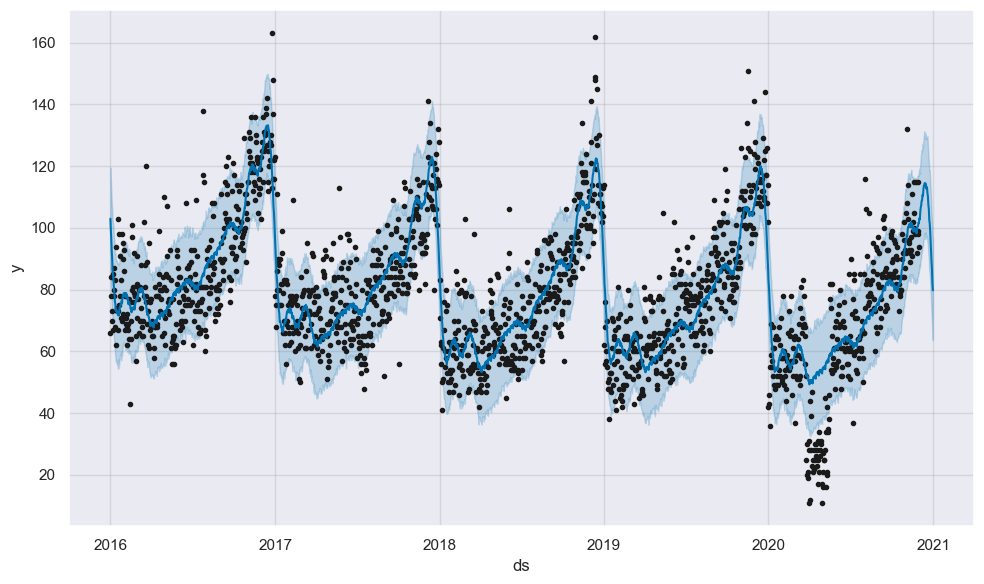

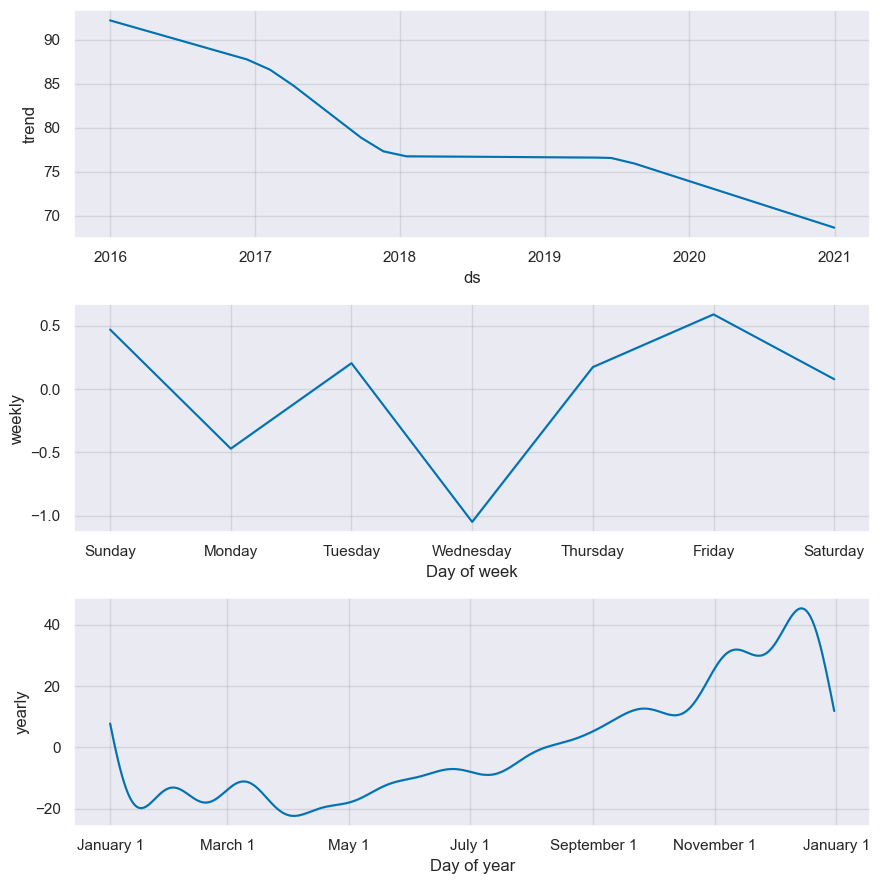

In [115]:
#Plot the prediction result, and ckeck out the trend/seasonality
forecast=prophet_basic.predict(future)
fig1 =prophet_basic.plot(forecast)
fig2 = prophet_basic.plot_components(forecast)

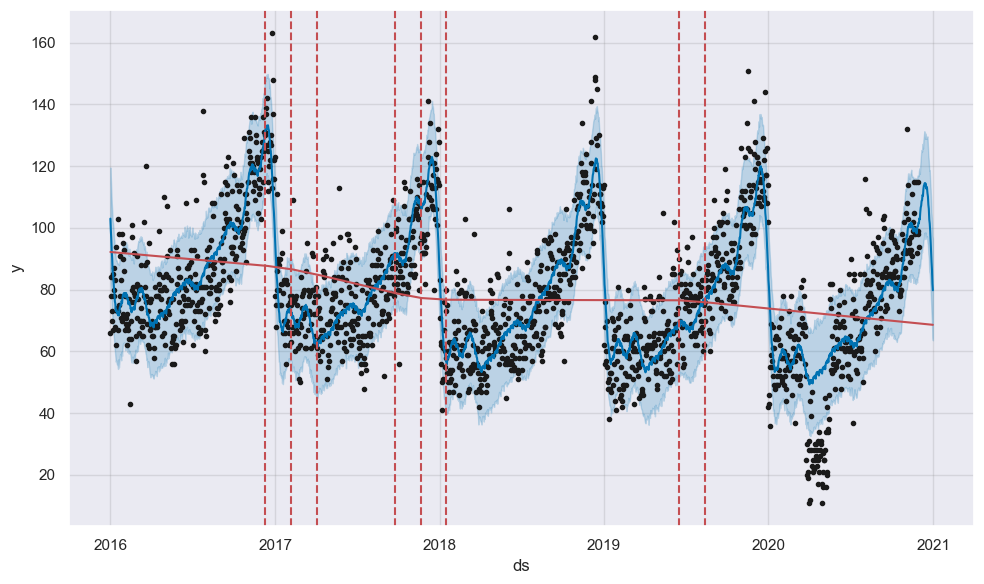

In [116]:
#add changepoint to plot to check trend and cut-off point
from prophet.plot import add_changepoints_to_plot
fig = prophet_basic.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet_basic, forecast)

In [117]:
prophet_basic.changepoints

57     2016-02-27
115    2016-04-25
172    2016-06-21
230    2016-08-18
287    2016-10-14
344    2016-12-10
402    2017-02-06
459    2017-04-04
517    2017-06-01
574    2017-07-28
631    2017-09-23
689    2017-11-20
746    2018-01-16
804    2018-03-15
861    2018-05-11
918    2018-07-07
976    2018-09-03
1033   2018-10-30
1091   2018-12-27
1148   2019-02-22
1205   2019-04-20
1263   2019-06-17
1320   2019-08-13
1378   2019-10-10
1435   2019-12-06
Name: ds, dtype: datetime64[ns]

07:51:39 - cmdstanpy - INFO - Chain [1] start processing
07:51:39 - cmdstanpy - INFO - Chain [1] done processing


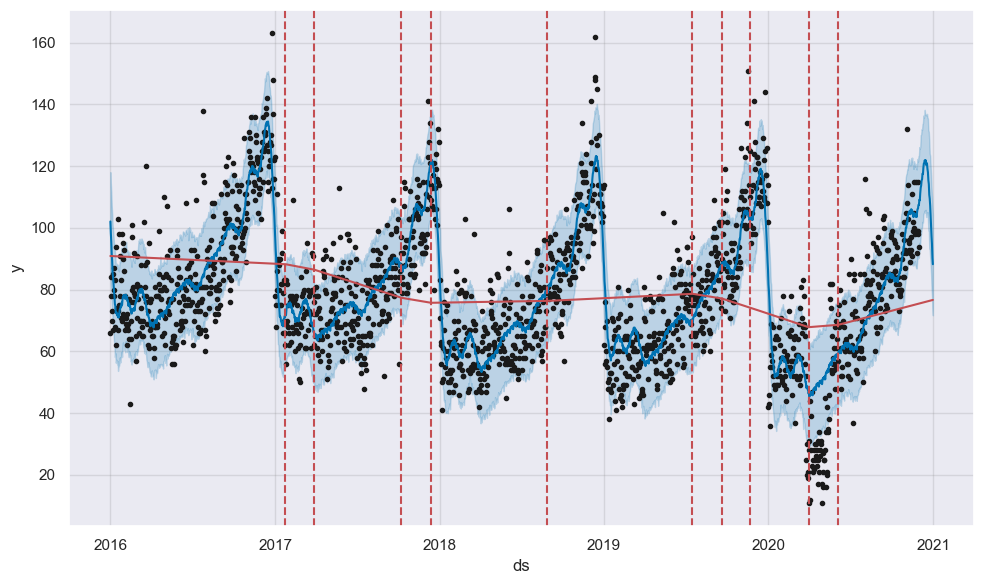

In [118]:
#modeify the parameters for the alternative prophet model
pro_change= Prophet(changepoint_range=0.9,yearly_seasonality=True,changepoint_prior_scale=0.08)
forecast = pro_change.fit(train_dataset).predict(future)
fig= pro_change.plot(forecast);
a = add_changepoints_to_plot(fig.gca(), pro_change, forecast)

In [119]:
#add addtional regressors to the new prophet model and prepare the traning and testing dataset
train_dataset['PositiveNews'] = x.reset_index()['PositiveNews']
train_dataset['NegativeCoverage'] = x.reset_index()['NegativeCoverage']
train_dataset['Competition'] = x.reset_index()['Competition']
train_dataset['0508Line_247'] = x.reset_index()['0508Line_247']
train_dataset['UltraEdition_Available'] = x.reset_index()['UltraEdition_Available']
train_dataset['COVID_Lockdown'] = x.reset_index()['COVID_Lockdown'] 
train_dataset['AdvertisingSpend'] = x.reset_index()['AdvertisingSpend']
train_dataset['Month'] = x.reset_index()['Month']
train_X= train_dataset
test_X= forecast_x.reset_index().rename(columns={'Date': 'ds'})

In [120]:
#Adding the regressors to the model and predict the new result
pro_regressor= Prophet()
pro_regressor.add_regressor('PositiveNews')
pro_regressor.add_regressor('NegativeCoverage')
pro_regressor.add_regressor('Competition')
pro_regressor.add_regressor('0508Line_247')
pro_regressor.add_regressor('UltraEdition_Available')
pro_regressor.add_regressor('COVID_Lockdown')
pro_regressor.add_regressor('AdvertisingSpend')
pro_regressor.add_regressor('Month')
#Fitting the data
pro_regressor.fit(train_X)
future_data = pro_regressor.make_future_dataframe(periods=31)
#forecast the data for Test  data
forecast_data = pro_regressor.predict(test_X)

07:51:40 - cmdstanpy - INFO - Chain [1] start processing
07:51:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

07:51:41 - cmdstanpy - INFO - Chain [1] start processing
07:51:41 - cmdstanpy - INFO - Chain [1] done processing
07:51:42 - cmdstanpy - INFO - Chain [1] start processing
07:51:42 - cmdstanpy - INFO - Chain [1] done processing


,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,36 days 12:00:00,92.466026,9.615926,7.909109,0.103546,0.077305,0.103698,0.506849
1,37 days 00:00:00,92.135330,9.598715,7.856524,0.102674,0.067377,0.102772,0.506849
2,37 days 12:00:00,93.155144,9.651691,7.917334,0.103802,0.077305,0.104028,0.493151
3,38 days 00:00:00,95.436313,9.769151,8.086693,0.106791,0.079114,0.106701,0.479452
4,38 days 12:00:00,96.848642,9.841171,8.220324,0.108556,0.086705,0.108593,0.465753


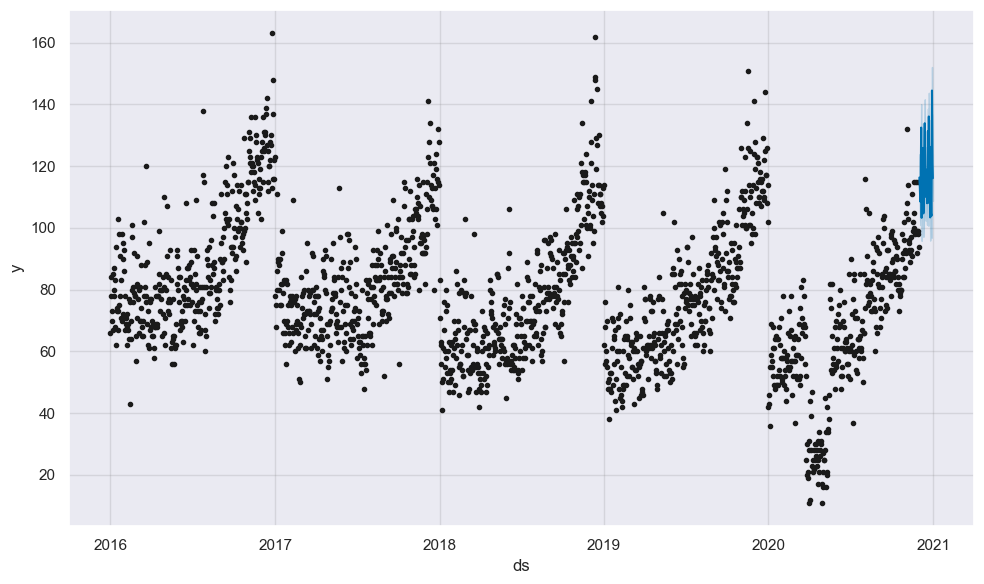

In [121]:
#Plot the new prediction result
pro_regressor.plot(forecast_data)
#cross validation the model and get the metrics to check the new model performance
from prophet.diagnostics import cross_validation
df_cv = cross_validation(pro_regressor, horizon = '365 days')
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

In [122]:
df_p
#Through the cross validation, the new model have the best MAPE and other metrics
#Therefore, we should use the new prophet to get the prediction of December sales

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,36 days 12:00:00,92.466026,9.615926,7.909109,0.103546,0.077305,0.103698,0.506849
1,37 days 00:00:00,92.135330,9.598715,7.856524,0.102674,0.067377,0.102772,0.506849
2,37 days 12:00:00,93.155144,9.651691,7.917334,0.103802,0.077305,0.104028,0.493151
3,38 days 00:00:00,95.436313,9.769151,8.086693,0.106791,0.079114,0.106701,0.479452
4,38 days 12:00:00,96.848642,9.841171,8.220324,0.108556,0.086705,0.108593,0.465753
...,...,...,...,...,...,...,...,...
653,363 days 00:00:00,448.864463,21.186422,17.362461,0.500488,0.149683,0.309548,0.232877
654,363 days 12:00:00,446.468860,21.129810,17.237106,0.499731,0.149683,0.308981,0.246575
655,364 days 00:00:00,435.174285,20.860831,16.958342,0.486252,0.144673,0.300675,0.246575
656,364 days 12:00:00,434.080340,20.834595,16.858237,0.485315,0.144673,0.299812,0.260274


In [123]:
forecast_data.rename(columns={'ds': "Date", "yhat": "Predicted Sales"},inplace=True)
forecast_data['Predicted Sales'] =forecast_data['Predicted Sales'].round(0)
result = forecast_data[['Date','Predicted Sales']]

In [124]:
result

,Date,Predicted Sales
0,2020-12-01,116.0
1,2020-12-02,113.0
2,2020-12-03,109.0
3,2020-12-04,113.0
4,2020-12-05,133.0
5,2020-12-06,103.0
6,2020-12-07,120.0
7,2020-12-08,115.0
8,2020-12-09,126.0
9,2020-12-10,105.0
